In [27]:
# Import necessary libraries for building, training, and visualizing the CNN model
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from google.colab import drive
from tensorflow.keras.preprocessing import image
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil

In [28]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:

zip_path = '/content/drive/My Drive/vehicle-dataset.zip'  # Update with your dataset's path
extract_path = '/content/vehicle_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [30]:

# Define paths to vehicle and non-vehicle directories
vehicle_dir = os.path.join(extract_path, 'data', 'vehicles')
non_vehicle_dir = os.path.join(extract_path, 'data', 'non-vehicles')

# Count the number of images in each class
vehicle_images = os.listdir(vehicle_dir)
non_vehicle_images = os.listdir(non_vehicle_dir)
print(f"Number of vehicle images: {len(vehicle_images)}")
print(f"Number of non-vehicle images: {len(non_vehicle_images)}")

Number of vehicle images: 8792
Number of non-vehicle images: 8968


In [31]:

train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
train_vehicle_dir = os.path.join(train_dir, 'vehicles')
test_vehicle_dir = os.path.join(test_dir, 'vehicles')
train_non_vehicle_dir = os.path.join(train_dir, 'non-vehicles')
test_non_vehicle_dir = os.path.join(test_dir, 'non-vehicles')
os.makedirs(train_vehicle_dir, exist_ok=True)
os.makedirs(test_vehicle_dir, exist_ok=True)
os.makedirs(train_non_vehicle_dir, exist_ok=True)
os.makedirs(test_non_vehicle_dir, exist_ok=True)

# Split the data into train and test sets
vehicle_train, vehicle_test = train_test_split(vehicle_images, test_size=0.2, random_state=42)
non_vehicle_train, non_vehicle_test = train_test_split(non_vehicle_images, test_size=0.2, random_state=42)

# Move files to the respective directories
for img in vehicle_train:
    shutil.move(os.path.join(vehicle_dir, img), train_vehicle_dir)
for img in vehicle_test:
    shutil.move(os.path.join(vehicle_dir, img), test_vehicle_dir)
for img in non_vehicle_train:
    shutil.move(os.path.join(non_vehicle_dir, img), train_non_vehicle_dir)
for img in non_vehicle_test:
    shutil.move(os.path.join(non_vehicle_dir, img), test_non_vehicle_dir)

In [59]:

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

# print(train_datagen)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 14207 images belonging to 2 classes.


In [60]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 3553 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.


In [61]:
# Calculate and display the number of batches
num_batches = train_generator.n // train_generator.batch_size
print(f"Number of batches: {num_batches}")

Number of batches: 443


In [62]:

from tensorflow.keras.layers import Dropout

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 16386     
                                                                 
Total params: 20040770 (76.45 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [63]:

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [65]:

# Train the model for a maximum of 5 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32
)

Epoch 1/5
13/13 [==============================] - 58s 5s/step - loss: 0.3974 - accuracy: 0.7957 - val_loss: 0.2361 - val_accuracy: 0.9167
Epoch 2/5
13/13 [==============================] - 58s 5s/step - loss: 0.1896 - accuracy: 0.9351 - val_loss: 0.1371 - val_accuracy: 0.9583
Epoch 3/5
13/13 [==============================] - 57s 4s/step - loss: 0.1498 - accuracy: 0.9495 - val_loss: 0.1230 - val_accuracy: 0.9792
Epoch 4/5
13/13 [==============================] - 58s 4s/step - loss: 0.1475 - accuracy: 0.9495 - val_loss: 0.1917 - val_accuracy: 0.9167
Epoch 5/5
13/13 [==============================] - 57s 4s/step - loss: 0.1155 - accuracy: 0.9688 - val_loss: 0.0731 - val_accuracy: 0.9896


In [66]:
model.evaluate(test_generator)

112/112 [==============================] - 397s 4s/step - loss: 0.1029 - accuracy: 0.9688


[0.10286769270896912, 0.9687588214874268]

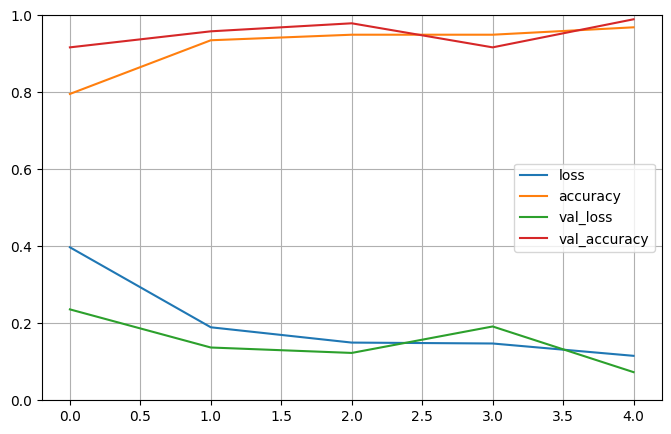

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [69]:
# Save the model in TensorFlow SavedModel format
model.save('/content/vehicle_model.keras')

In [70]:
from tensorflow import keras

# Load the saved model
loaded_model = keras.models.load_model('vehicle_model.keras')

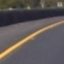

In [81]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the correct function

image = cv2.imread('/content/vehicle_dataset/test/non-vehicles/extra1003.png')
cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow

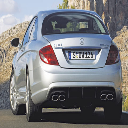

In [89]:
test_image = cv2.resize(image,(128,128))
cv2_imshow(test_image)

In [90]:
test_image = np.reshape(test_image,[1,128,128,3])

In [91]:
prediction = loaded_model.predict(test_image)

1/1 [==============================] - 0s 422ms/step


In [92]:
prediction

array([[0., 1.]], dtype=float32)

In [93]:
classes = ['NonVehicle','Vehicle']

In [94]:
classes[np.argmax(prediction)]

'Vehicle'

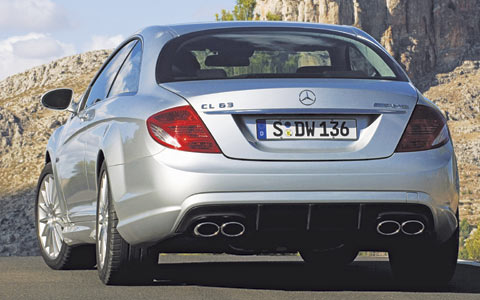

In [88]:
image = cv2.imread('GxOg5.jpg')
cv2_imshow(image)